C:\Pytorch\Lib\site-packages\pytorch_msssim\ssim.py:48: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  out = conv(out, weight=win.transpose(2 + i, -1), stride=1, padding=0, groups=C)


Epoch [0/5], Step [0/913], Loss D: 0.7995, Loss G: 40.9185
Epoch [0/5], Step [50/913], Loss D: 0.1199, Loss G: 8.7943
Epoch [0/5], Step [100/913], Loss D: 0.6805, Loss G: 4.9177
Epoch [0/5], Step [150/913], Loss D: 0.6475, Loss G: 5.9572
Epoch [0/5], Step [200/913], Loss D: 0.5688, Loss G: 4.8358
Epoch [0/5], Step [250/913], Loss D: 0.6741, Loss G: 3.7710
Epoch [0/5], Step [300/913], Loss D: 0.4724, Loss G: 3.9531
Epoch [0/5], Step [350/913], Loss D: 0.4928, Loss G: 4.5033
Epoch [0/5], Step [400/913], Loss D: 0.5328, Loss G: 4.3596
Epoch [0/5], Step [450/913], Loss D: 0.3985, Loss G: 4.7762
Epoch [0/5], Step [500/913], Loss D: 0.3815, Loss G: 6.2713
Epoch [0/5], Step [550/913], Loss D: 0.1195, Loss G: 8.2359
Epoch [0/5], Step [600/913], Loss D: 0.0197, Loss G: 8.5538
Epoch [0/5], Step [650/913], Loss D: 0.0424, Loss G: 7.4157
Epoch [0/5], Step [700/913], Loss D: 0.0129, Loss G: 9.0943
Epoch [0/5], Step [750/913], Loss D: 0.8943, Loss G: 5.6017
Epoch [0/5], Step [800/913], Loss D: 0.861

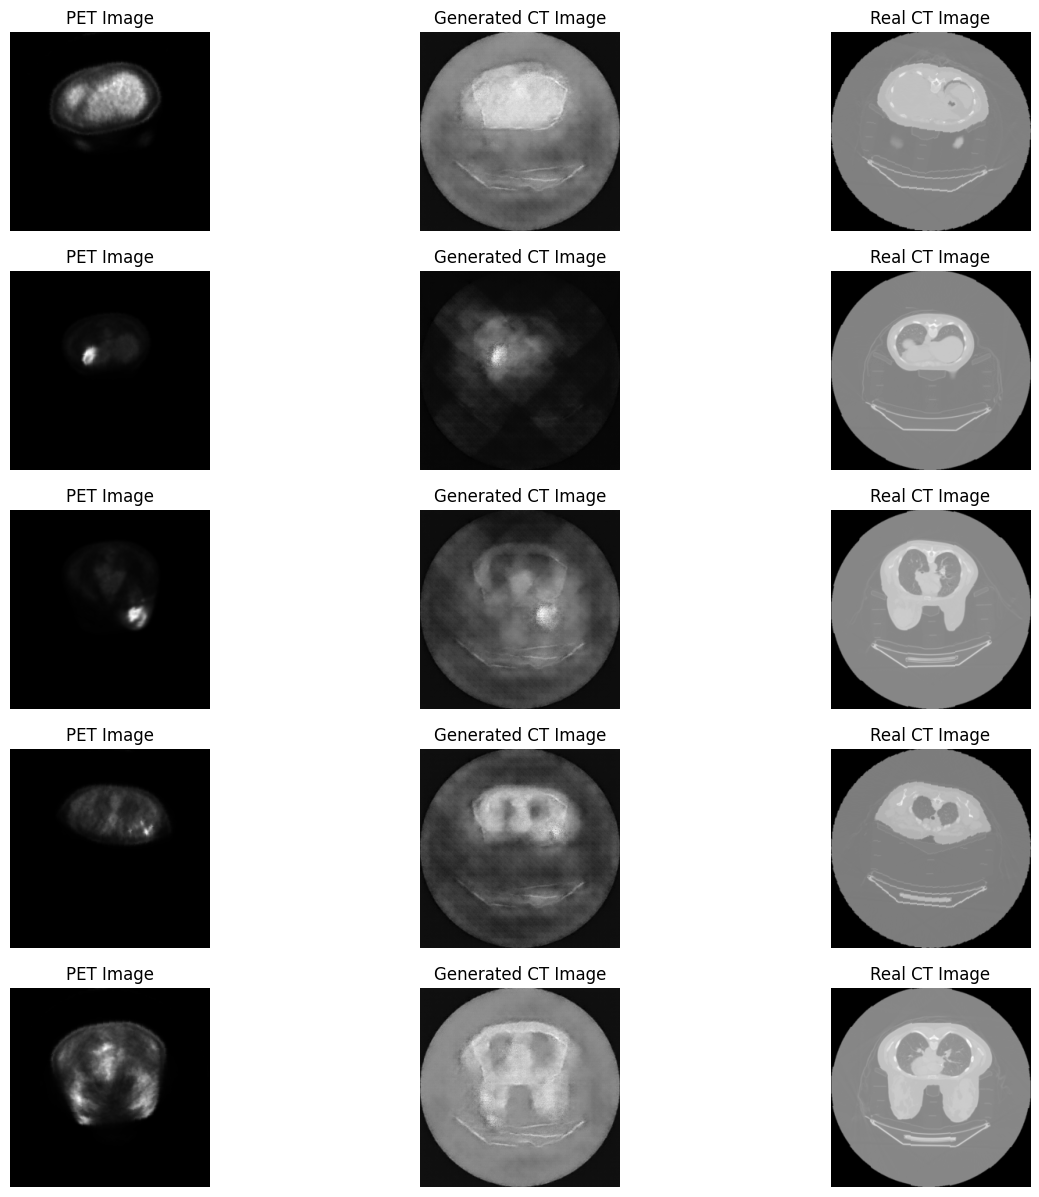

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from pytorch_msssim import ssim
from PIL import Image
import os

# Dataset class
class DicomDataset(Dataset):
    def __init__(self, pet_folder, ct_folder, transform=None):
        self.pet_folder = pet_folder
        self.ct_folder = ct_folder
        self.transform = transform
        self.pet_images = sorted(os.listdir(pet_folder))
        self.ct_images = sorted(os.listdir(ct_folder))

    def __len__(self):
        return len(self.pet_images)

    def __getitem__(self, idx):
        pet_path = os.path.join(self.pet_folder, self.pet_images[idx])
        ct_path = os.path.join(self.ct_folder, self.ct_images[idx])
        pet_image = pydicom.dcmread(pet_path).pixel_array.astype(np.float32)
        ct_image = pydicom.dcmread(ct_path).pixel_array.astype(np.float32)

        pet_image = (pet_image - np.min(pet_image)) / (np.max(pet_image) - np.min(pet_image))
        ct_image = (ct_image - np.min(ct_image)) / (np.max(ct_image) - np.min(ct_image))

        pet_image = Image.fromarray(pet_image)
        ct_image = Image.fromarray(ct_image)

        if self.transform:
            pet_image = self.transform(pet_image)
            ct_image = self.transform(ct_image)

        return pet_image, ct_image

# U-Net Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            layers.append(nn.BatchNorm2d(out_channels))
            if dropout:
                layers.append(nn.Dropout(0.5))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        self.enc1 = down_block(in_channels, 64, batch_norm=False)
        self.enc2 = down_block(64, 128)
        self.enc3 = down_block(128, 256)
        self.enc4 = down_block(256, 512)
        self.enc5 = down_block(512, 512)
        self.enc6 = down_block(512, 512)
        self.enc7 = down_block(512, 512)
        self.enc8 = down_block(512, 512, batch_norm=False)

        self.dec1 = up_block(512, 512, dropout=True)
        self.dec2 = up_block(1024, 512, dropout=True)
        self.dec3 = up_block(1024, 512, dropout=True)
        self.dec4 = up_block(1024, 512)
        self.dec5 = up_block(1024, 256)
        self.dec6 = up_block(512, 128)
        self.dec7 = up_block(256, 64)
        self.dec8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        enc6 = self.enc6(enc5)
        enc7 = self.enc7(enc6)
        enc8 = self.enc8(enc7)

        dec1 = self.dec1(enc8)
        dec2 = self.dec2(torch.cat([dec1, enc7], 1))
        dec3 = self.dec3(torch.cat([dec2, enc6], 1))
        dec4 = self.dec4(torch.cat([dec3, enc5], 1))
        dec5 = self.dec5(torch.cat([dec4, enc4], 1))
        dec6 = self.dec6(torch.cat([dec5, enc3], 1))
        dec7 = self.dec7(torch.cat([dec6, enc2], 1))
        dec8 = self.dec8(torch.cat([dec7, enc1], 1))

        return dec8

# PatchGAN Discriminator
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels):
        super(PatchDiscriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            discriminator_block(in_channels, 64, batch_norm=False),
            discriminator_block(64, 128),
            discriminator_block(128, 256),
            discriminator_block(256, 512, stride=1, padding=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Initialize models
generator = UNetGenerator(in_channels=1, out_channels=1).cuda()
discriminator = PatchDiscriminator(in_channels=2).cuda()

generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.5, 0.999))

# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Dataset and Dataloader
pet_folder = "D:\\Thesis Content\\manifest-1542731172463\\PET_IMAGES"
ct_folder = "D:\\Thesis Content\\manifest-1542731172463\\CT_IMAGES"
dataset = DicomDataset(pet_folder, ct_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Training function
def train(generator, discriminator, dataloader, num_epochs=5, lambda_L1=100, lambda_SSIM=10):
    for epoch in range(num_epochs):
        for i, (pet_image, ct_image) in enumerate(dataloader):
            pet_image, ct_image = pet_image.cuda(), ct_image.cuda()

            # Train Discriminator
            optimizer_D.zero_grad()

            # Real images
            real_output = discriminator(torch.cat((pet_image, ct_image), 1))
            real_labels = torch.ones_like(real_output).cuda()
            loss_D_real = criterion_GAN(real_output, real_labels)

            # Fake images
            fake_image = generator(pet_image)
            fake_output = discriminator(torch.cat((pet_image, fake_image.detach()), 1))
            fake_labels = torch.zeros_like(fake_output).cuda()
            loss_D_fake = criterion_GAN(fake_output, fake_labels)

            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            fake_output = discriminator(torch.cat((pet_image, fake_image), 1))
            loss_G_GAN = criterion_GAN(fake_output, real_labels)
            loss_G_L1 = criterion_L1(fake_image, ct_image) * lambda_L1
            loss_G_SSIM = (1 - ssim(fake_image, ct_image)) * lambda_SSIM
            loss_G = loss_G_GAN + loss_G_L1 + loss_G_SSIM

            loss_G.backward()
            optimizer_G.step()


            if i % 50 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                      f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")


# Evaluation function
def evaluate_model(generator, dataloader):
    generator.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for pet_image, ct_image in dataloader:
            pet_image, ct_image = pet_image.cuda(), ct_image.cuda()
            fake_image = generator(pet_image)

            pet_image = pet_image.cpu().numpy().squeeze()
            ct_image = ct_image.cpu().numpy().squeeze()
            fake_image = fake_image.cpu().numpy().squeeze()

            psnr_value = peak_signal_noise_ratio(ct_image, fake_image)
            ssim_value = structural_similarity(ct_image, fake_image, data_range=1.0)

            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")


# Visualization function
def visualize_results(generator, dataloader, num_images=5):
    generator.eval()
    plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (pet_image, ct_image) in enumerate(dataloader):
            if i >= num_images:
                break

            pet_image, ct_image = pet_image.cuda(), ct_image.cuda()
            fake_image = generator(pet_image)

            pet_image = pet_image.cpu().numpy().squeeze()
            ct_image = ct_image.cpu().numpy().squeeze()
            fake_image = fake_image.cpu().numpy().squeeze()

            plt.subplot(num_images, 3, i * 3 + 1)
            plt.imshow(pet_image, cmap='gray')
            plt.title('PET Image')
            plt.axis('off')

            plt.subplot(num_images, 3, i * 3 + 2)
            plt.imshow(fake_image, cmap='gray')
            plt.title('Generated CT Image')
            plt.axis('off')

            plt.subplot(num_images, 3, i * 3 + 3)
            plt.imshow(ct_image, cmap='gray')
            plt.title('Real CT Image')
            plt.axis('off')

    plt.show()


# Example usage
train(generator, discriminator, dataloader, num_epochs=5, lambda_L1=100)
evaluate_model(generator, dataloader)
visualize_results(generator, dataloader)


In [2]:
pip install "numpy<2"


Note: you may need to restart the kernel to use updated packages.
